# Parts of the Notebook:
* [Build dataset](#data_set)
* [Feature extraction](#feature_extraction)

In [1]:
# Required Modules
import pandas as pd
import numpy as np
import nltk
import time
import os
import io

import matplotlib.pyplot as plt
%matplotlib inline

<a id='data_set'></a>
## Build Corpus

### Import File Set
Load data from all files and join it into a single dataframe

In [2]:
import re
fpath='./data/'
df = None
count_articles = 0
count_files = 0
for fname in os.listdir(fpath):
    
    if re.search("csv$",fname):
        
        df_tmp = pd.read_csv(open(fpath+fname,'rt',encoding = 'utf-8'),sep=",",encoding = 'utf-8')
        print('{} --- Read Lines: {}'.format(fname,df_tmp.shape[0]))
        
        # Select columns.
        df_tmp=df_tmp[["Document Title","Abstract","IEEE Terms","Article Citation Count","Start Page","INSPEC Controlled Terms"]]
        
        count_files = count_files+1
        
        if df is None:
            df = df_tmp
        else:
            df = df.append(df_tmp)

print('Total Lines: {}'.format(df.shape[0]))


export_iotj_2015-2017.csv --- Read Lines: 496
export_jsac_2015-2017.csv --- Read Lines: 1037
export_globecom_2017.csv --- Read Lines: 1237
export_icc_2016.csv --- Read Lines: 1087
export_sj_2016.csv --- Read Lines: 1214
export_twc_2015-2017.csv --- Read Lines: 1958
export_wcommletters_2015-2017.csv --- Read Lines: 622
export_globecom_2015.csv --- Read Lines: 1214
export_globecom_2016.csv --- Read Lines: 1207
export_icc_2017.csv --- Read Lines: 1403
export_sj_2017.csv --- Read Lines: 1095
export_toii_2015-2017.csv --- Read Lines: 823
export_tmc_2015-2017.csv --- Read Lines: 677
export_wcnc_2015-2017.csv --- Read Lines: 1677
export_sj_2015.csv --- Read Lines: 948
export_commsmag_2015-2017.csv --- Read Lines: 1457
export_commletters_2015-2017.csv --- Read Lines: 2000
export_icc_2015.csv --- Read Lines: 1754
export_sensors_2015-2017.csv --- Read Lines: 1666
export_infocom_2015-2017.csv --- Read Lines: 1635
Total Lines: 25207


### Filter Docs
Remove docs with wrong format. Drop duplicates.  

In [3]:
# Remove non-numeric "Page Number" items (select articles from other docs)
print('Pre "Start Page" count: {}'.format(df.shape[0]))
Dinx=df["Start Page"].apply(lambda x: str(x).isnumeric())
df=df[Dinx]        

# Drop duplicates
print('Pre-duplicates: {}'.format(df.shape[0]))
Dinx = df.duplicated()
df.drop_duplicates(inplace=True)
print('Post-duplicates: {}'.format(df.shape[0]))            
       
print('Total Items: {}'.format(df.shape[0]))
print('Mean Citation Count: {}'.format(df["Article Citation Count"].mean()))
                       
print(df[["Document Title"]].head())  
print(df[["Document Title"]].tail())  

Pre "Start Page" count: 25207
Pre-duplicates: 24280
Post-duplicates: 24128
Total Items: 24128
Mean Citation Count: 4.900978654542652
                                      Document Title
0  SD-NFV as an Energy Efficient Approach for M2M...
3  Performance Analysis of Plant Monitoring Nanos...
4  Optimized Day-Ahead Pricing With Renewable Ene...
5  Computing Resource Allocation in Three-Tier Io...
6  Resource Design in Constrained Networks for Ne...
                                         Document Title
1630  The untrusted handover security of the S-PMIPv...
1631  To achieve Massive MIMO with much less antenna...
1632           Latency analysis for distributed storage
1633  Towards efficient radio resource scheduling in...
1634  Ensemble feature selection with discriminative...


### Filter Data and Cleaning
* Remove docs different from articles
* Filter by selected tokens in abstracts

In [4]:
dfc=df.copy()

# Remove Titles with Specific Pattern (Non articles)
Inx=dfc["Document Title"].str.contains(pat='\[|Table of Contents|Editorial|Information for Authors|Keynotes|Copyright notice|Blank page',case=False,regex=True)
dfc=dfc[~Inx]

# Restrict to "wireless"
Inx=dfc["Abstract"].str.contains(pat='lora|sigfox|lpwa|tsch|wireless|wifi|mmwave|wsn|lte|millim|mmw|rfid|zigbe|blueto|vanet|4g|5g',case=False,regex=True)
dfc=dfc[Inx]

# Restrict to "industry"
# Inx=dfc["Abstract"].str.contains(pat='industr',case=False,regex=True)
# dfc=dfc[Inx]

# Restrict to "manufact"
# Inx=dfc["Abstract"].str.contains(pat='manufact',case=False,regex=True)
# dfc=dfc[Inx]

# Set Integer Index
dfc.index=range(len(dfc.index))

print(dfc[["Document Title"]].head())  
print(dfc[["Document Title"]].tail()) 

                                      Document Title
0  SD-NFV as an Energy Efficient Approach for M2M...
1  Performance Analysis of Plant Monitoring Nanos...
2  Optimized Day-Ahead Pricing With Renewable Ene...
3  An Analysis of RFID Authentication Schemes for...
4  An Adaptive Edge Router Enabling Internet of T...
                                         Document Title
8975                        Understanding rollover data
8976  RFlow<sup>+</sup>: An SDN-based WLAN monitorin...
8977  Demo abstract: Sender-triggered selective wake...
8978  The untrusted handover security of the S-PMIPv...
8979  Towards efficient radio resource scheduling in...


### Select Column
Build bag-of-words from selected column:

In [5]:
# Select column for analysis (copy to new dataframe)

#bow=dfc["Abstract"].copy()
#bow.dropna(inplace=True)

#bow=dfc["Document Title"].copy()
#bow.dropna(inplace=True)

# bow=dfc["IEEE Terms"].copy()
# bow.dropna(inplace=True)

bow=dfc["INSPEC Controlled Terms"].copy()
bow.dropna(inplace=True)

# Check-save
bow.to_csv("./tmp/bow_INSPEC.csv",index=True)

print('Total Size: {}'.format(bow.shape[0]))
print(bow.head(5))
print(bow.tail(5))


Total Size: 8851
0    C++ language;cloud computing;computer network ...
1           biology computing;wireless sensor networks
2    Internet of Things;convex programming;demand s...
3    Internet of Things;health care;public key cryp...
4    Internet of Things;queueing theory;telecommuni...
Name: INSPEC Controlled Terms, dtype: object
8975     Internet;mobile radio;telecommunication services
8976    IP networks;computer network management;comput...
8977    radio transceivers;software radio;wireless sen...
8978    4G mobile communication;IP networks;Long Term ...
8979    Long Term Evolution;prediction theory;quality ...
Name: INSPEC Controlled Terms, dtype: object


<a id='feature_extraction'></a>
## Feature Extraction

### Load data 
Load from temporal file (optional)

In [6]:
bow=pd.Series.from_csv("./tmp/bow_INSPEC.csv", index_col=0,header=None)

display(bow.head(5))
display(bow.tail(5))
display(len(bow.index))

0    C++ language;cloud computing;computer network ...
1           biology computing;wireless sensor networks
2    Internet of Things;convex programming;demand s...
3    Internet of Things;health care;public key cryp...
4    Internet of Things;queueing theory;telecommuni...
dtype: object

8975     Internet;mobile radio;telecommunication services
8976    IP networks;computer network management;comput...
8977    radio transceivers;software radio;wireless sen...
8978    4G mobile communication;IP networks;Long Term ...
8979    Long Term Evolution;prediction theory;quality ...
dtype: object

8851

### Raw NLTK Analysis

In [7]:
# Split Key-words by ';'
lst=[]
for index, row in bow.iteritems():
    lst=lst+row.split(sep=';')

# Convert to Lower Case (not required for INSPEC terms)    
# lst = [x.lower() for x in lst]

# Use FreqDist Class inherit from native Dict
fdist = nltk.FreqDist(lst) 

# Save Results in temporal file
pd.DataFrame(data=fdist.most_common(),columns=['keyword','count']).to_csv("./tmp/keywords_freq.csv", sep="\t",index=True)

# Show List
display(fdist.most_common(20))

[('wireless sensor networks', 1256),
 ('cellular radio', 1071),
 ('wireless channels', 933),
 ('5G mobile communication', 921),
 ('telecommunication power management', 849),
 ('Long Term Evolution', 812),
 ('MIMO communication', 772),
 ('telecommunication traffic', 706),
 ('radiofrequency interference', 678),
 ('wireless LAN', 673),
 ('optimisation', 654),
 ('radio networks', 612),
 ('probability', 585),
 ('resource allocation', 537),
 ('quality of service', 521),
 ('energy harvesting', 500),
 ('relay networks (telecommunication)', 481),
 ('telecommunication network reliability', 474),
 ('array signal processing', 442),
 ('energy conservation', 438)]

### Display Results

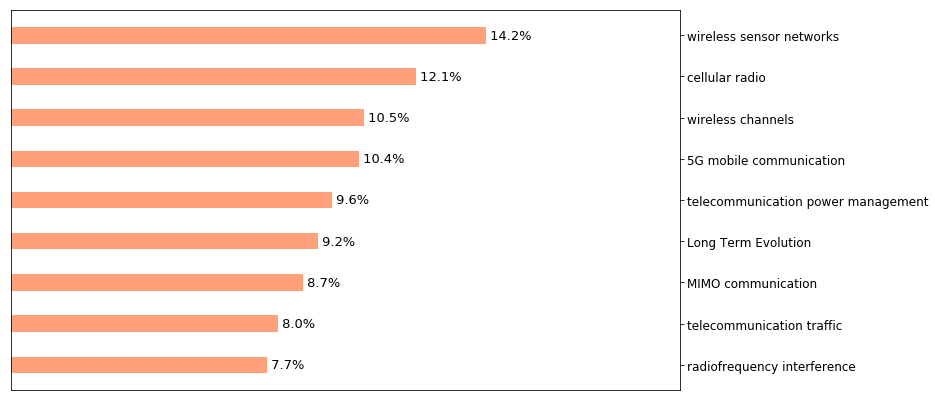

In [8]:
# Number Bars to Show
NumBars=9

keyword=[x[0] for x in fdist.most_common(NumBars)]
count=[x[1] for x in fdist.most_common(NumBars)]

TotalSize=len(bow.index)
count = [100*float(i)/TotalSize  for i in count]

#------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------

fig,axes = plt.subplots(ncols=1,figsize=(12,7))
fig.facecolor='black'

keyword.reverse()
count.reverse()

axes.barh(y=range(len(keyword)),width=count, align='center', color="#ffa07a",height=0.4)
axes.set_yticks(range(len(keyword)))
axes.set_yticklabels(keyword)

axes.yaxis.tick_right()

axes.set_xticks(np.arange(0, 25, step=5))


axes.tick_params(axis='x', labelsize=12, bottom=False, top=False, labelbottom=False)
axes.tick_params(axis='y', labelsize=12)


for i, v in enumerate(count):
    axes.text(v , i , " "+str(round(v,1))+'%' , color='black', va='center', fontsize=13 ) #, fontweight='bold' + ' ({0}/{1})'.format(y2[i],8866)

plt.show()
